In [1]:
import yaml
import torch
import torchaudio
import torchaudio.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from drasdic.models.model import get_model
from drasdic.inference.interface import InferenceInterface
from drasdic.inference.inference_utils import load_audio
from IPython import display as ipd

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [3]:
def plot_spectrogram(audio_tensor, sample_rate, events_df=None):
    """
    Plots a spectrogram from an audio tensor and overlays bounding boxes
    for sound events stored in a pandas DataFrame.

    Parameters:
        audio_tensor (torch.Tensor): The audio waveform tensor.
        sample_rate (int): The sample rate of the audio.
        events_df (pd.DataFrame): A DataFrame containing bounding box information
                                  with columns "Begin Time (s)" and "End Time (s)".
    """
    # Convert to spectrogram
    spec_transform = transforms.Spectrogram()
    spec = spec_transform(audio_tensor)
    spec_db = torchaudio.transforms.AmplitudeToDB()(spec)

    # Plot spectrogram
    fig, ax = plt.subplots(figsize=(10, 5))
    img = ax.imshow(spec_db.squeeze().numpy(), origin='lower', aspect='auto', cmap='viridis',
                     extent=[0, audio_tensor.shape[1] / sample_rate, 0, spec_db.shape[1]])
    
    # Overlay bounding boxes
    if events_df is not None:
        for _, row in events_df.iterrows():
            start_time, end_time = row["Begin Time (s)"], row["End Time (s)"]
            ax.add_patch(plt.Rectangle((start_time, 0), end_time - start_time, spec_db.shape[1],
                                       edgecolor=(1,0,0,1), facecolor=(1,0,0,0.1), linewidth=2))
    
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency Bin")
    plt.colorbar(img, ax=ax, label='dB')
    plt.show()

# Load audio

In [4]:
sr = 16000

# Load audios
audio = load_audio('/home/jupyter/data/fewshot_data/evaluation/formatted_notused/WMW/audio/XC100296.wav', sr)
support_dur_sec = 10
support_audio = audio[:int(support_dur_sec*sr)]
query_audio = audio[int(support_dur_sec*sr):]

# support selection table
selection_table = pd.read_csv('/home/jupyter/data/fewshot_data/evaluation/formatted_notused/WMW/selection_tables/XC100296.txt', sep='\t')
support_st = selection_table[selection_table["Begin Time (s)"] <= support_dur_sec]
query_st = selection_table[selection_table["End Time (s)"] > support_dur_sec]

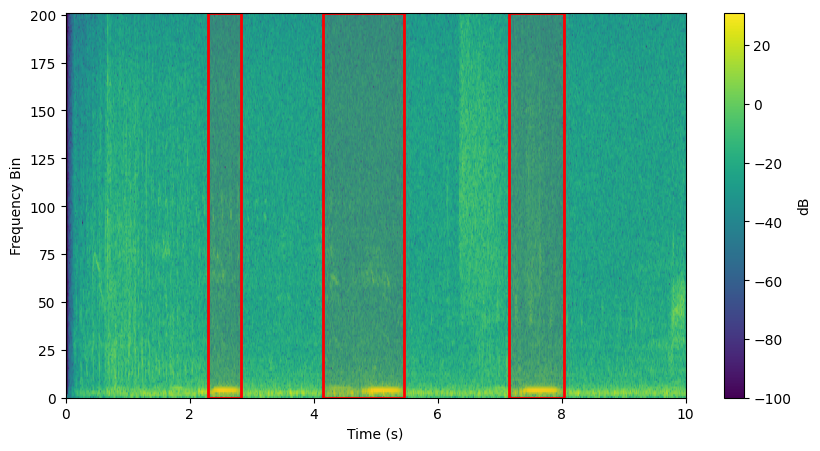

In [5]:
plot_spectrogram(support_audio.unsqueeze(0), sr, support_st)

In [6]:
ipd.Audio(support_audio, rate=sr)

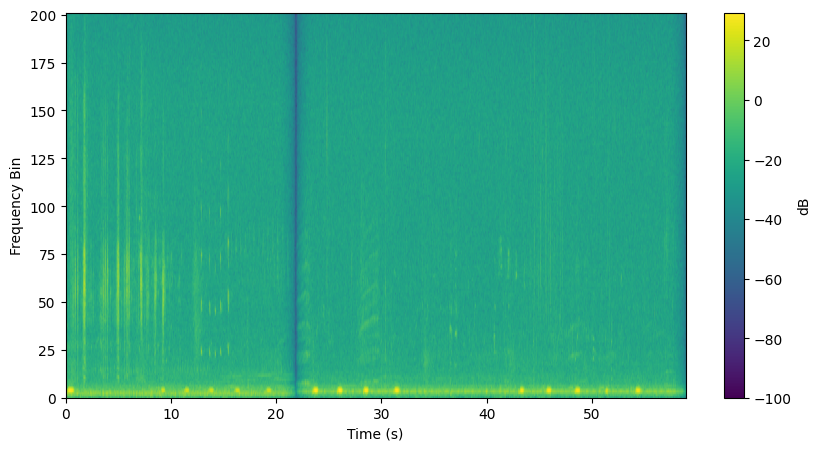

In [7]:
plot_spectrogram(query_audio.unsqueeze(0), sr)

In [8]:
ipd.Audio(query_audio, rate=sr)

# Load DRASDIC

In [9]:
with open("/home/jupyter/drasdic/weights/main_model/eval_config_r9.yaml", "r") as f:
    model_config = yaml.safe_load(f)
    
interface = InferenceInterface(model_config)

loading model weights from /home/jupyter/drasdic/weights/main_model/random_9/model_80000.pt


# Prompt DRASDIC with training data

In [10]:
interface.load_support(support_audio, support_st, pos_label='c_16')
print("Training data loaded")

Training data loaded


# Inference

100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


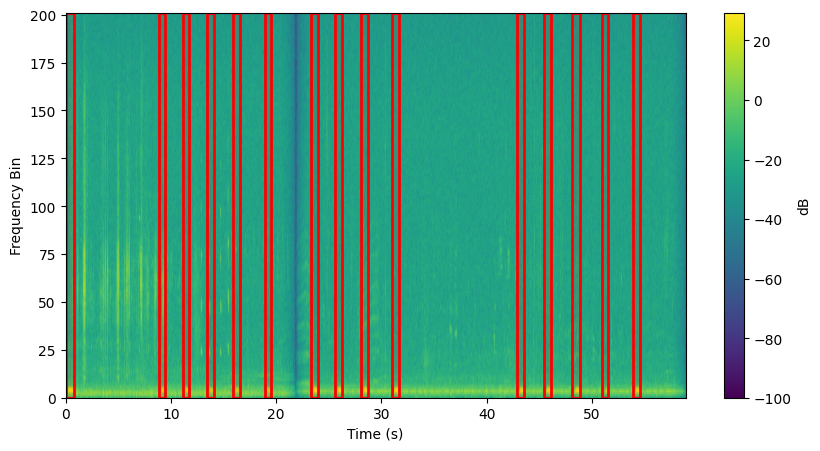

In [11]:
predicted_st = interface.predict(query_audio)
plot_spectrogram(query_audio.unsqueeze(0), sr, predicted_st)

# Harder Example

In [12]:
# Load audios
sr= 16000
support_start_sec = 2400
audio = load_audio('/home/jupyter/data/carrion_crows_data/19/AL/Naranja/1007.wav', sr)
support_audio = audio[int(support_start_sec * sr):int(support_start_sec * sr) + int(30*sr)]
query_audio = audio[-int(3600*sr):]

# support selection table
selection_table = pd.read_csv('/home/jupyter/data/carrion_crows_data/Annotations_revised_by_Daniela.cleaned/selection_tables/19_AL_Naranja_1007.txt', sep='\t')
support_st = selection_table[(selection_table["Begin Time (s)"] >= support_start_sec) & (selection_table["End Time (s)"] < support_start_sec + 30)]
support_st["Begin Time (s)"] -= support_start_sec
support_st["End Time (s)"] -= support_start_sec

/tmp/ipykernel_21522/2188672207.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  support_st["Begin Time (s)"] -= support_start_sec
/tmp/ipykernel_21522/2188672207.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  support_st["End Time (s)"] -= support_start_sec


In [13]:
support_st[support_st["Annotation"] == "focal"].sort_values("Begin Time (s)")

Selection           View  Channel  Begin Time (s)  End Time (s)  \
331        367  Spectrogram 1        1        7.825658      8.156117   
332        368  Spectrogram 1        1       10.876433     11.384094   
333        369  Spectrogram 1        1       14.090021     14.377376   
334        370  Spectrogram 1        1       14.750938     14.999979   
335        371  Spectrogram 1        1       15.052682     15.210727   

     Low Freq (Hz)  High Freq (Hz)  Delta Time (s)  Delta Freq (Hz)  \
331            0.0        2028.245          0.3305         2028.245   
332            0.0        3042.368          0.5077         3042.368   
333            0.0        2478.966          0.2874         2478.966   
334            0.0        2704.327          0.2490         2704.327   
335            0.0        2929.688          0.1580         2929.688   

     Avg Power Density (dB FS/Hz) Annotation  
331                        -40.90      focal  
332                        -42.63      focal  
333                        -41.84      focal  
334                        -42.17      focal  
335                        -42.57      focal

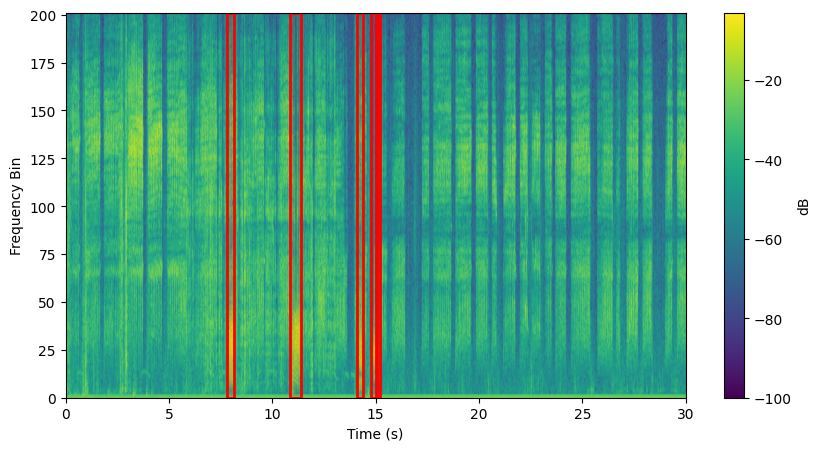

In [14]:
plot_spectrogram(support_audio.unsqueeze(0), sr, support_st[support_st["Annotation"] == "focal"])

In [15]:
ipd.Audio(support_audio, rate=sr)

In [16]:
interface.load_support(support_audio, support_st, pos_label='focal')
print("Training data loaded")
predicted_st = interface.predict(query_audio)

Training data loaded


100%|██████████| 1/1 [00:33<00:00, 33.54s/it]


In [17]:
predicted_st

Begin Time (s)  End Time (s) Annotation
0           58.96         59.14      focal
1          736.72        737.00      focal
2         1671.22       1671.52      focal
3         2013.26       2013.54      focal

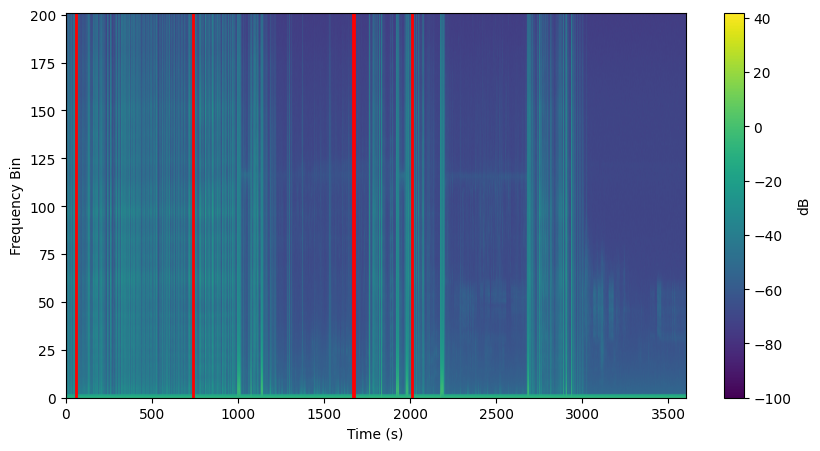

In [18]:
plot_spectrogram(query_audio.unsqueeze(0), sr, predicted_st)

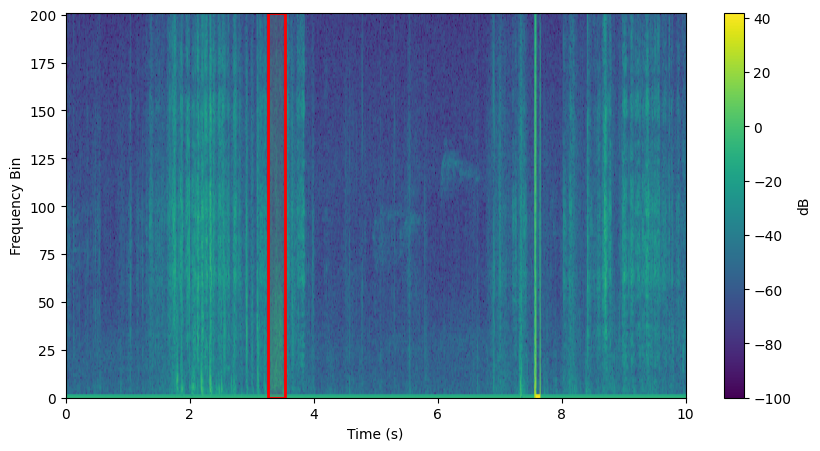

In [19]:
predicted_st_shifted = predicted_st.copy()
predicted_st_shifted["Begin Time (s)"] -= 2010
predicted_st_shifted["End Time (s)"] -= 2010
plot_spectrogram(query_audio[2010*sr:2020*sr].unsqueeze(0), sr, predicted_st_shifted)

In [20]:
ipd.Audio(query_audio[2010*sr:2020*sr], rate=sr)